In [64]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import log2
import copy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from des import des_enc_list

In [65]:
df_train = pd.read_csv('DES_TRAIN.csv')
df_test = pd.read_csv('DES_TEST.csv')

In [66]:
NUM_MSG_BYTES = 8
NUM_KEY_BYTES = 7

def embed(df):
    key = np.multiply(df['K0'].to_numpy(), df['K1'].to_numpy())
    
    inputs = df.iloc[:, :(2 * NUM_MSG_BYTES)].values
    return inputs, key

In [67]:
inputs, labels = embed(df_train)
inputs

array([[143, 183, 166, ...,   3,  72, 126],
       [ 55,  49, 105, ..., 221, 101, 194],
       [  7, 166,  66, ...,  47,  68,  48],
       ...,
       [ 75, 185, 163, ..., 137, 106, 253],
       [100,  80, 220, ...,  65,  47, 161],
       [164,  15,  43, ..., 153,  95, 181]], dtype=int64)

In [68]:
model = DecisionTreeRegressor(min_samples_leaf=50)
model.fit(inputs, labels)

DecisionTreeRegressor(min_samples_leaf=50)

In [69]:
df_train.head()

,M0,M1,M2,M3,M4,M5,M6,M7,C0,C1,...,C6,C7,K0,K1,K2,K3,K4,K5,K6,K7
0,143,183,166,120,131,201,40,30,56,172,...,72,126,38,236,221,89,56,65,172,NaN
1,55,49,105,113,255,64,154,163,53,72,...,101,194,185,109,112,61,81,231,76,NaN
2,7,166,66,59,98,252,118,126,198,34,...,68,48,95,22,117,230,31,51,0,NaN
3,36,161,192,222,177,164,123,40,3,95,...,127,183,38,59,124,165,93,128,87,NaN
4,220,25,117,194,26,123,71,157,10,148,...,146,70,109,235,160,236,39,76,112,NaN


In [70]:
predictions = model.predict(inputs)
error = np.abs(predictions - labels)
mean_error = np.mean(error)
max_error = np.max(error)
print('Average train error: ', mean_error)
#print('Average exponent train error: ', log2(mean_error))
print('Max train error: ', max_error)
#print('Max exponent train error: ', log2(max_error + 1))
print('Min train error: ', np.min(error))

Average train error:  11021.516647200422
Max train error:  55605.21538461538
Min train error:  0.0


In [71]:
inputs_test, labels_test = embed(df_test)

In [72]:
print(labels[:5])
df_test.head()

[ 8968 20165  2090  2242 25615]


,M0,M1,M2,M3,M4,M5,M6,M7,C0,C1,...,C6,C7,K0,K1,K2,K3,K4,K5,K6,K7
0,65,68,79,13,212,77,121,199,158,9,...,225,189,142,49,82,244,83,233,77,NaN
1,87,90,127,177,147,241,250,111,32,22,...,78,51,9,103,207,36,33,97,147,NaN
2,245,232,239,102,156,110,137,5,52,57,...,120,176,232,179,193,97,131,98,78,NaN
3,82,97,172,131,223,176,36,247,174,62,...,6,29,219,166,23,104,199,29,237,NaN
4,245,228,67,73,69,200,143,254,102,91,...,118,141,197,202,214,74,224,221,6,NaN


In [73]:
print(np.abs(np.array(model.predict(inputs_test[:5])) - np.array(labels_test[:5])))

[14294.67857143 10382.83333333 24748.77192982 24012.63043478
 10686.66666667]


In [74]:
predictions_test = model.predict(inputs_test)
error = np.abs(predictions_test - labels_test)
mean_error = np.mean(error)
max_error = np.max(error)
print('Average error: ', mean_error)
#print('Average exponent error: ', log2(mean_error))
print('Max error: ', max_error)
print('Min error: ', np.min(error))
#print('Max exponent error: ', log2(max_error))

Average error:  12230.658772477595
Max error:  57880.032258064515
Min error:  0.0


In [75]:
def prob(dist, d):
    if d not in dist:
        return 0
    return dist[d]

<BarContainer object of 81749 artists>

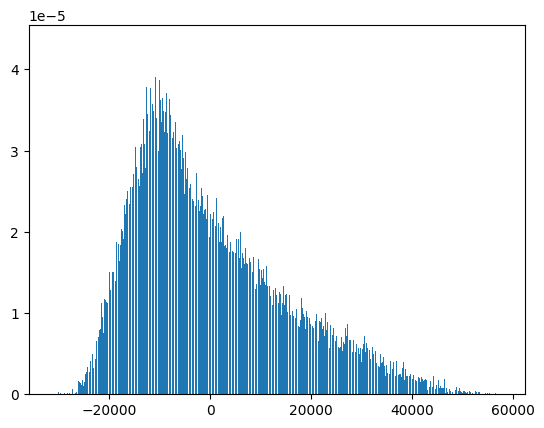

In [76]:
from collections import Counter
import math

predictions_test = np.array([math.floor(p) for p in predictions_test])
error_dist = (labels_test - predictions_test)
error_dist = dict(Counter(error_dist))
dists = np.array(list(error_dist.keys()))
freq = np.array(list(error_dist.values())) / len(predictions_test)
error_dist = dict(zip(dists, freq))
plt.bar(dists, freq)

13090 25287
Calculated distribution


<BarContainer object of 131072 artists>

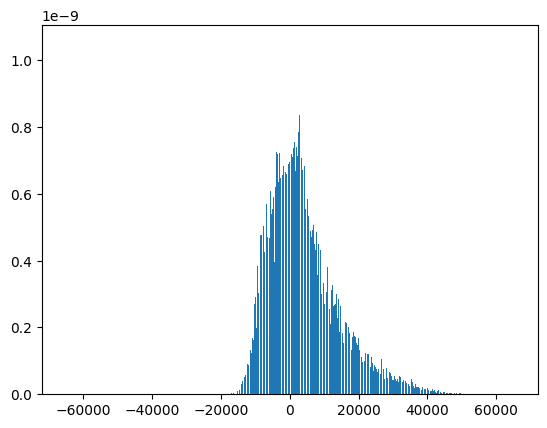

In [80]:
MSG1 = [121, 22, 234, 112, 23, 10, 55, 24]
MSG2 = [54, 63, 23, 54, 11, 0, 42, 13]

KEY = [255, 255, 30, 40, 50, 60, 70]

C1 = des_enc_list(copy.deepcopy(KEY), MSG1)
C2 = des_enc_list(copy.deepcopy(KEY), MSG2)

key_bar1 = math.floor(model.predict([[*MSG1, *C1]])[0])
key_bar2 = math.floor(model.predict([[*MSG2, *C2]])[0])

k2 = min(key_bar1, key_bar2)
k1 = max(key_bar1, key_bar2)

delta = abs(k2 - k1)

print(k2, k1)
p1 = {}

for d in range(-2**16, 2**16):
    p1[d] = prob(error_dist, d) * prob(error_dist, d - delta)

print('Calculated distribution')

plt.bar(list(p1.keys()), list(p1.values()))

Calculated distribution


<BarContainer object of 131072 artists>

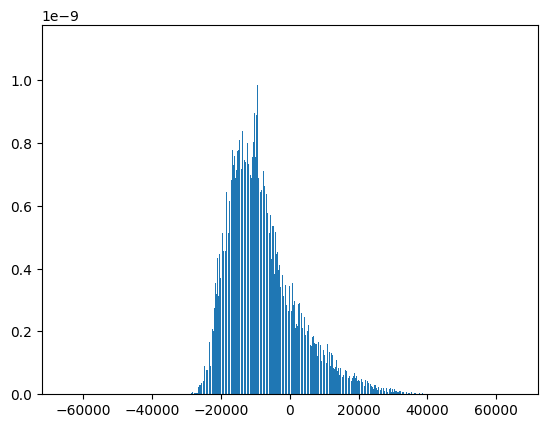

In [85]:
p11 = {}

for d in range(-2**16, 2**16):
    p11[d] = prob(error_dist, d) * prob(error_dist, d + delta)

print('Calculated distribution')

plt.bar(list(p11.keys()), list(p11.values()))

In [82]:
left = 0
for d in range(-2**16, 0):
    left += prob(p1, d)

right = 0
de = 0
for d in range(0, 2**16):
    right += prob(p1, d)
    de += prob(p1, d) * d

print(left, right)
print(max(left, right))
print(de)

6.109830346666667e-06 9.189312888889702e-06
9.189312888889702e-06
0.09229282004896072


In [86]:
MSG1 = [121, 22, 234, 112, 23, 10, 55, 24]
MSG2 = [54, 63, 23, 54, 11, 0, 42, 13]
MSG3 = [132, 52, 33, 42, 145, 111, 134, 13]

KEY = [10, 20, 30, 40, 50, 60, 70]

C1 = des_enc_list(copy.deepcopy(KEY), MSG1)
C2 = des_enc_list(copy.deepcopy(KEY), MSG2)
C3 = des_enc_list(copy.deepcopy(KEY), MSG3)

key_bar1 = math.floor(model.predict([[*MSG1, *C1]])[0])
key_bar2 = math.floor(model.predict([[*MSG2, *C2]])[0])
key_bar3 = math.floor(model.predict([[*MSG3, *C3]])[0])

k2 = min(key_bar1, key_bar2)
k1 = max(key_bar1, key_bar2)

k3 = min(k2, key_bar3)

print(k3, k1)

12332 23594
